In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import sys
from pathlib import Path
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

project_root = Path(os.getcwd()).resolve().parents[0]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Carrega .env
load_dotenv(override=True)

# Configura o estilo dos gráficos
sns.set_theme(style="whitegrid")

## Carregar Dados

### Conectar ao BD PostgreSQL   

In [4]:
# Conectar ao Banco de Dados PostgreSQL
db_user = os.getenv("PG_USER")
db_pass = os.getenv("PG_PASSWORD")
db_host = os.getenv("PG_HOST")
db_port = os.getenv("PG_PORT")
db_name = os.getenv("PG_DB")

connection_string = f'postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)

print("Conectado ao PostgreSQL!")

Conectado ao PostgreSQL!


### Carregar as Tabelas

In [5]:
# --- 2. Carregar Tabelas Normalizadas ---
# (Ajuste os nomes das tabelas se você os salvou de forma diferente)
with engine.connect() as conn:
    df_projetos = pd.read_sql(text('SELECT * FROM dados_projetos'), conn)
    
    # Vamos assumir que as tabelas normalizadas também foram salvas.
    # Estas tabelas podem ter múltiplas linhas por projeto (ex: múltiplos executores)
    df_eixos = pd.read_sql(text('SELECT * FROM dados_eixos'), conn)
    df_fontes = pd.read_sql(text('SELECT * FROM dados_fontes_recurso'), conn)
    df_executores = pd.read_sql(text('SELECT * FROM dados_executores'), conn)

print(f"Projetos carregados: {len(df_projetos)}")

Projetos carregados: 800


### Criacao de DataFrame (Visualizacao)

In [6]:

# --- 3. Criar DataFrame de Análise Mestre ---
# Para esta análise, vamos focar nos valores de investimento e eixos.
# Vamos agregar as fontes de recurso por projeto (somando o valor)
df_investimento = df_fontes.groupby('id_unico')['valor_investimento_previsto'].sum().reset_index()

# Vamos pegar o *primeiro* eixo e executor de cada projeto (simplificação para os gráficos)
df_eixo_primario = df_eixos.drop_duplicates(subset='id_unico')
df_executor_primario = df_executores.drop_duplicates(subset='id_unico')

# Juntar tudo em um DataFrame de visualização
df_viz = df_projetos.merge(df_investimento, on='id_unico', how='left')
df_viz = df_viz.merge(df_eixo_primario, on='id_unico', how='left', suffixes=('', '_eixo'))
df_viz = df_viz.merge(df_executor_primario, on='id_unico', how='left', suffixes=('', '_exec'))

print("DataFrame de visualização mestre criado com sucesso.")

DataFrame de visualização mestre criado com sucesso.


C:\Users\tigor\AppData\Local\Temp\ipykernel_1384\774413750.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


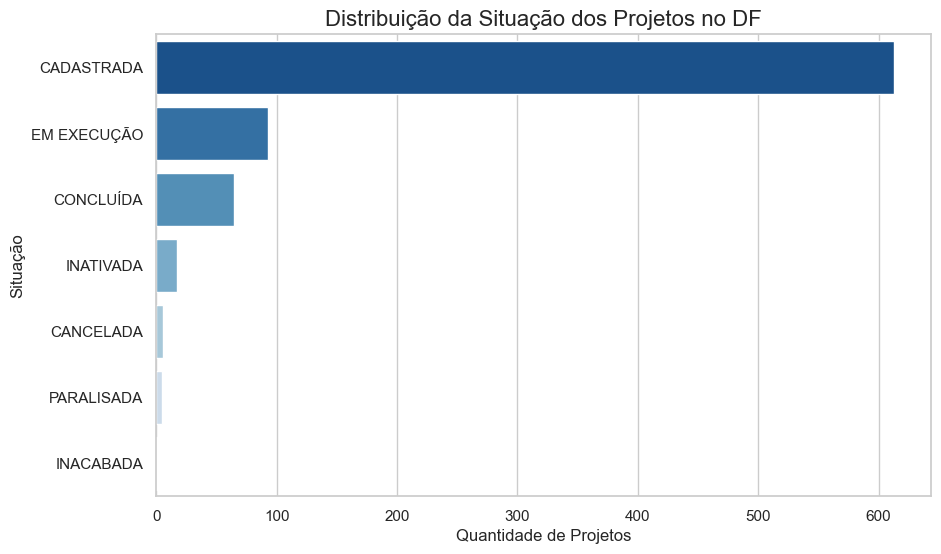

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_viz, 
    y='situacao', 
    order=df_viz['situacao'].value_counts().index,
    palette='Blues_r'
)
plt.title('Distribuição da Situação dos Projetos no DF', fontsize=16)
plt.xlabel('Quantidade de Projetos', fontsize=12)
plt.ylabel('Situação', fontsize=12)
plt.show()

In [ ]:
import matplotlib.ticker as ticker

# Filtra dados sem valor ou sem descrição de eixo
df_plot = df_viz.dropna(subset=['valor_investimento_previsto', 'descricao'])

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_plot,
    x='descricao', # O Eixo
    hue='valor_investimento_previsto', # O Valor
    palette='pastel'
)

# Essencial: Usar escala logarítmica para o valor
plt.yscale('log')
plt.title('Distribuição do Valor dos Projetos por Eixo (Escala Log)', fontsize=16)
plt.xlabel('Eixo Estratégico', fontsize=12)
plt.ylabel('Valor Previsto (R$) - Escala Log', fontsize=12)
plt.xticks(rotation=45)

# Formata o eixo Y para mostrar valores em Reais (R$ 1M, R$ 1B)
@ticker.FuncFormatter
def human_format(x, pos):
    if x >= 1e9:
        return f'R$ {x/1e9:.0f} Bi'
    if x >= 1e6:
        return f'R$ {x/1e6:.0f} Mi'
    if x >= 1e3:
        return f'R$ {x/1e3:.0f} Mil'
    return f'R$ {x:.0f}'

plt.gca().yaxis.set_major_formatter(human_format)
plt.show()

C:\Users\tigor\AppData\Local\Temp\ipykernel_1384\4143061622.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




In [10]:
# (Usando 'descricao' do df_eixo_primario)
fig = px.treemap(
    df_viz.dropna(subset=['valor_investimento_previsto', 'descricao']),
    path=[px.Constant("Todos os Eixos"), 'descricao'], # 'descricao' é o nome do Eixo
    values='valor_investimento_previsto',
    color='valor_investimento_previsto',
    color_continuous_scale='Blues',
    title='Valor Total de Investimento por Eixo Estratégico'
)
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

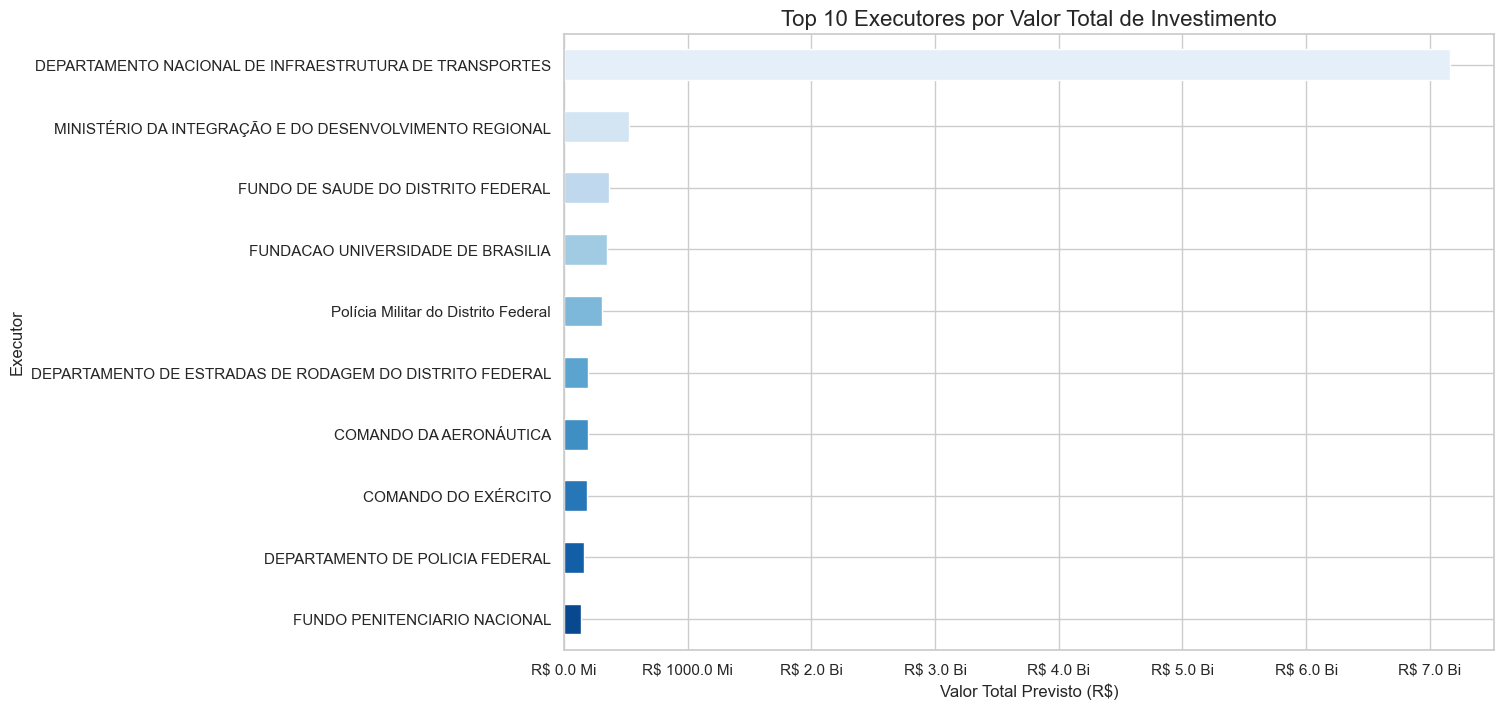

In [27]:
# (Usando 'nome' do df_executor_primario)
# Agrupando por nome do executor e somando o valor
top_10_executores = df_viz.groupby('nome_exec')['valor_investimento_previsto'] \
                        .sum().nlargest(10).sort_values()

plt.figure(figsize=(12, 8))
top_10_executores.plot(kind='barh', color=sns.color_palette('Blues_r', 10))
plt.title('Top 10 Executores por Valor Total de Investimento', fontsize=16)
plt.xlabel('Valor Total Previsto (R$)', fontsize=12)
plt.ylabel('Executor', fontsize=12) # O label do eixo Y está correto

# Formata o eixo X para Moeda (Milhões/Bilhões)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1e9:.1f} Bi' if x > 1e9 else f'R$ {x/1e6:.1f} Mi'))
plt.show()

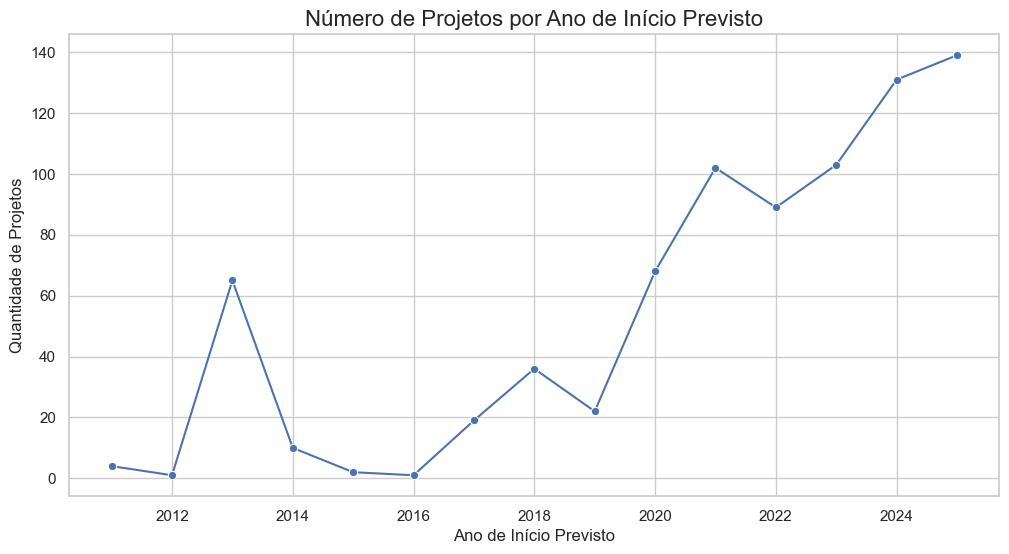

In [26]:
# Extrai o ano da data_inicial_prevista
df_viz['ano_inicio_previsto'] = df_viz['data_inicial_prevista'].dt.year

# Agrupa por ano e conta os projetos
projetos_por_ano = df_viz.groupby('ano_inicio_previsto')['id_unico'].count().reset_index()

# Filtra anos com dados razoáveis (ex: > 2010)
projetos_por_ano = projetos_por_ano[projetos_por_ano['ano_inicio_previsto'] > 2010]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=projetos_por_ano, 
    x='ano_inicio_previsto', 
    y='id_unico', 
    marker='o'
)
plt.title('Número de Projetos por Ano de Início Previsto', fontsize=16)
plt.xlabel('Ano de Início Previsto', fontsize=12)
plt.ylabel('Quantidade de Projetos', fontsize=12)
plt.show()

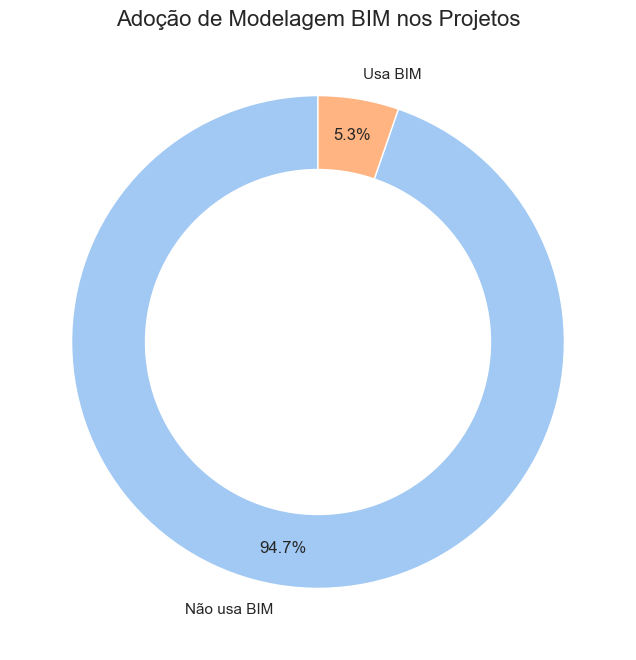

In [14]:
bim_counts = df_viz['is_modelada_por_bim'].value_counts()
labels = ['Não usa BIM', 'Usa BIM']
colors = sns.color_palette('pastel')[0:2]

plt.figure(figsize=(8, 8))
plt.pie(
    bim_counts, 
    labels=labels, 
    colors=colors, 
    autopct='%.1f%%', 
    startangle=90, 
    pctdistance=0.85
)

# Desenha o círculo branco para fazer o "Donut"
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Adoção de Modelagem BIM nos Projetos', fontsize=16)
plt.show()

In [15]:
# Filtra dados onde temos tanto o valor quanto a qdt de empregos
df_scatter = df_viz.dropna(subset=['valor_investimento_previsto', 'qdt_empregos_gerados'])
df_scatter = df_scatter[df_scatter['qdt_empregos_gerados'] > 0] # Remove zeros

fig = px.scatter(
    df_scatter,
    x='valor_investimento_previsto',
    y='qdt_empregos_gerados',
    log_x=True,  # Escala log no investimento é crucial
    log_y=True,  # Escala log em empregos também pode ajudar
    hover_name='nome',
    hover_data=['situacao'],
    title='Relação entre Investimento (Log) e Empregos Gerados (Log)',
    labels={'valor_investimento_previsto': 'Investimento Previsto (R$ - Log)', 'qdt_empregos_gerados': 'Empregos Gerados (Log)'}
)
fig.show()

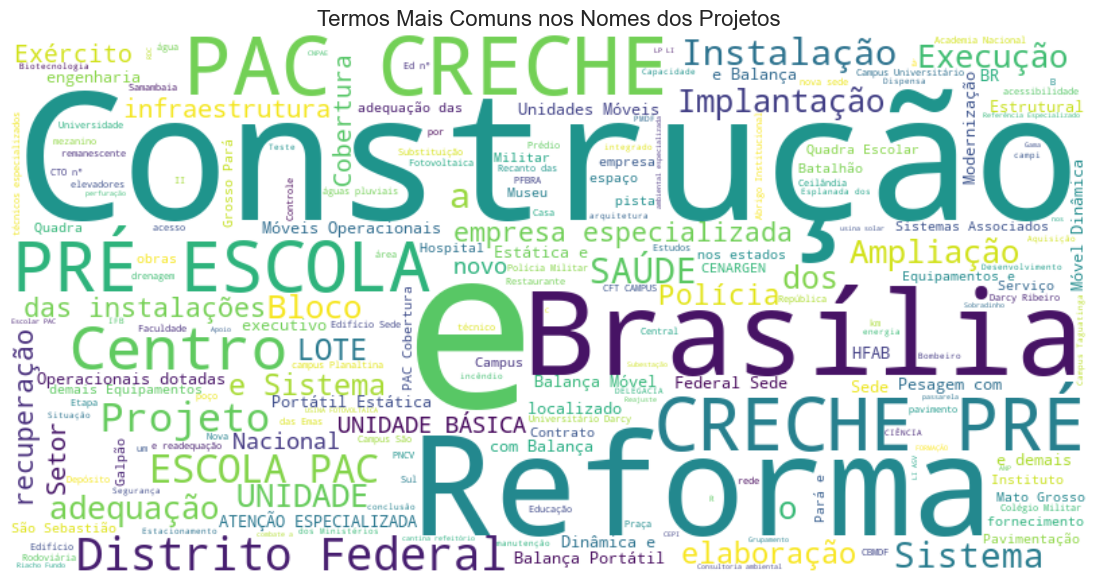

In [24]:
from wordcloud import WordCloud

# 1. Concatena todo o texto da coluna 'nome' em uma única string
# (Remove nulos antes)
text = " ".join(nome for nome in df_viz.nome.dropna())

# 2. Define stopwords (palavras comuns a ignorar)
# Adicione palavras irrelevantes que aparecerem
stopwords = set(['de', 'do', 'da', 'para', 'em', 'DF', 'Contratação', 'Serviços', 'DL', 'no', 'na', 'Obra'])

# 3. Gera a Nuvem de Palavras
wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
    width=800,
    height=400,
    colormap='viridis'
).generate(text)

# 4. Plota a imagem
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Termos Mais Comuns nos Nomes dos Projetos', fontsize=16)
plt.show()